# Overview
In this notebook, we will analyze customer data and try to come with a decent model that is able to predict customer churn giver several features of customers. Exploratory data analysis was performed to assess relationships among different variables and multiple classification algorithms were used and compared. The dataset comes from Kaggle and can be found [here](https://www.kaggle.com/blastchar/telco-customer-churn).

## 1. Data Import

In [49]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [50]:
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [51]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [52]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [53]:
#total charge column is string type, has empty string values
min(data.TotalCharges)

' '

In [54]:
data.TotalCharges[data.TotalCharges==" "] = np.nan

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [55]:
data.loc[:,"TotalCharges"] = data.TotalCharges.astype(float)

In [56]:
#missing some values in total charges, delete them since a very small percentage
data.isnull().mean()
data.shape

(7043, 21)

In [57]:
data = data.dropna()

## 2. EDA
- Most variables are categorical variables, their relationships with churn can be visualized using bar charts.
- Distribution of customer-specific features can be visualized to identify patterns.
- Boxplots can be used to identify impact of numerical variables on churn.

<AxesSubplot:ylabel='Churn'>

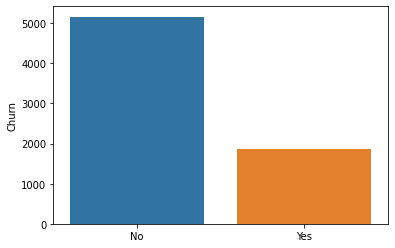

In [58]:
#Many more not-churned customers
churn = data["Churn"].value_counts()
sns.barplot(churn.index,churn)

<AxesSubplot:ylabel='gender'>

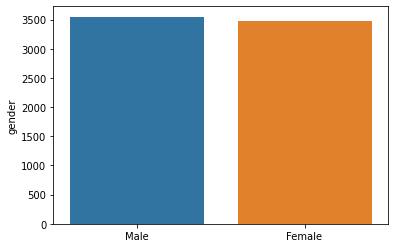

In [59]:
#data is balanced for gender
gender = data["gender"].value_counts()
sns.barplot(gender.index,gender)

<AxesSubplot:xlabel='MonthlyCharges'>

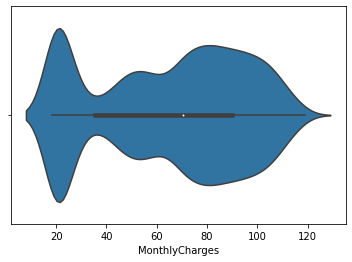

In [60]:
#distribution of monthly charges: median charge is between 60 to 80 dollars
sns.violinplot(data["MonthlyCharges"])

<AxesSubplot:xlabel='TotalCharges'>

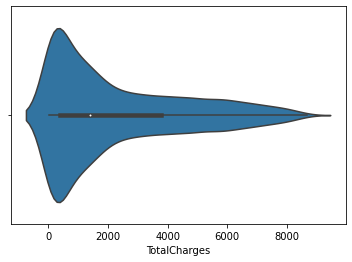

In [61]:
#distribution of total charges, median is below 2000, the distribution is right-skewed.
sns.violinplot(data["TotalCharges"])

<AxesSubplot:xlabel='tenure'>

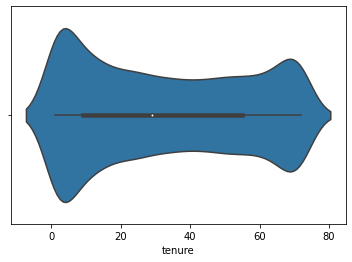

In [62]:
#distribution of tenure is bi-modal
sns.violinplot(data["tenure"])

### Explore relationships between charges, tenure and churn

<AxesSubplot:xlabel='Churn', ylabel='MonthlyCharges'>

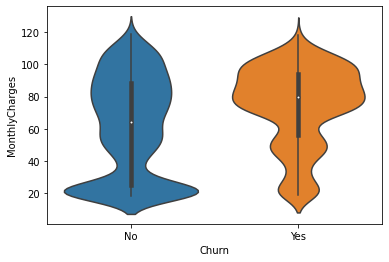

In [63]:
sns.violinplot("Churn","MonthlyCharges",data=data)

<AxesSubplot:xlabel='Churn', ylabel='TotalCharges'>

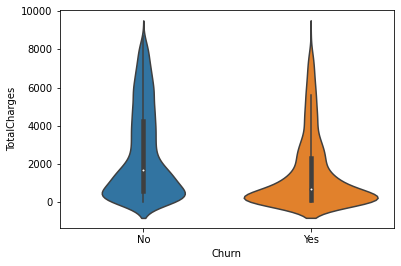

In [64]:
sns.violinplot("Churn","TotalCharges",data=data)

Churned customers seem to have a higher monthly charge, but less total charge, which makes sense since the duration is shorter for churned customers.

<AxesSubplot:xlabel='Churn', ylabel='tenure'>

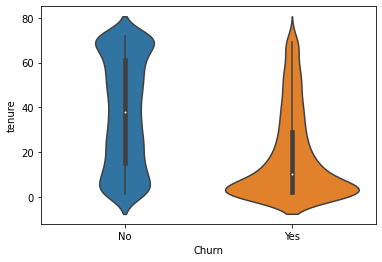

In [65]:
#As expected, churned customers have a much lower median tenure
sns.violinplot("Churn","tenure",data=data)

<AxesSubplot:xlabel='SeniorCitizen', ylabel='tenure'>

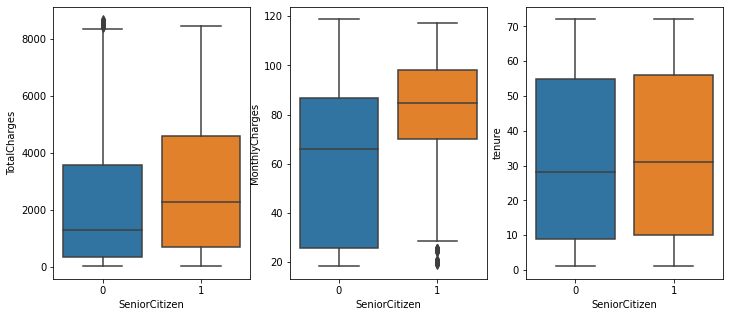

In [66]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(12,5))
sns.boxplot("SeniorCitizen","TotalCharges",data=data,ax=ax[0])
sns.boxplot("SeniorCitizen","MonthlyCharges",data=data,ax=ax[1])
sns.boxplot("SeniorCitizen","tenure",data=data,ax=ax[2])

Senior citizens paid a higher median total charge and monthly charge, however, there are some outliers of high total charge among non-senior citizens and very low montly charge among senior citizens. There is not a huge difference in tenures.

<AxesSubplot:xlabel='Partner', ylabel='tenure'>

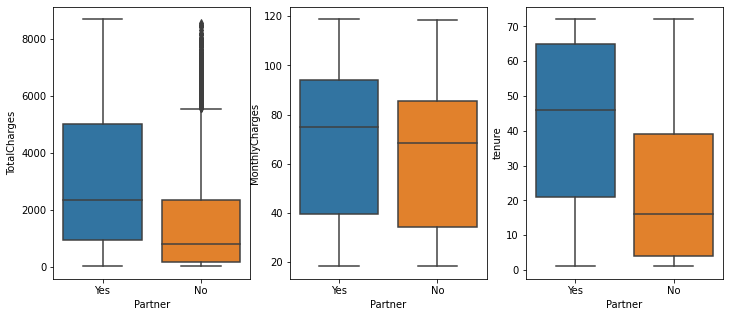

In [67]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(12,5))
sns.boxplot("Partner","TotalCharges",data=data,ax=ax[0])
sns.boxplot("Partner","MonthlyCharges",data=data,ax=ax[1])
sns.boxplot("Partner","tenure",data=data,ax=ax[2])

<AxesSubplot:xlabel='Dependents', ylabel='tenure'>

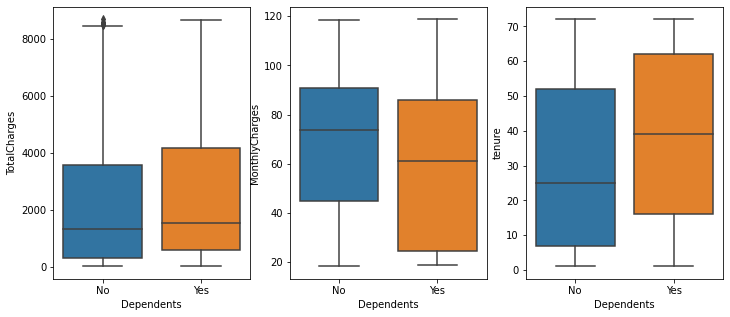

In [68]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(12,5))
sns.boxplot("Dependents","TotalCharges",data=data,ax=ax[0])
sns.boxplot("Dependents","MonthlyCharges",data=data,ax=ax[1])
sns.boxplot("Dependents","tenure",data=data,ax=ax[2])

Comment on partner and dependents

### Contract and Billing Method vs. Churn

<AxesSubplot:xlabel='Contract', ylabel='customer counts'>

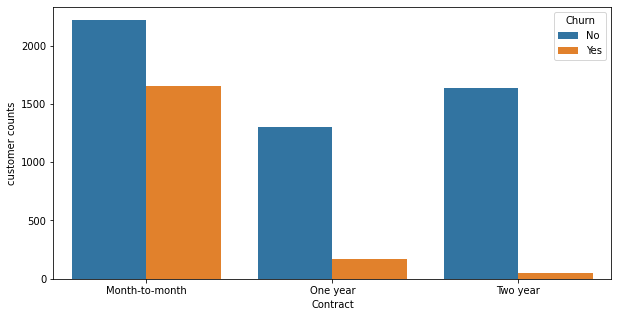

In [69]:
plt.figure(figsize=(10,5))
contract = data.groupby(["Contract","Churn"]).size().to_frame().reset_index()
contract = contract.rename(columns={0:"customer counts"})
sns.barplot("Contract","customer counts",hue="Churn",data=contract)

<AxesSubplot:xlabel='PaymentMethod', ylabel='customer counts'>

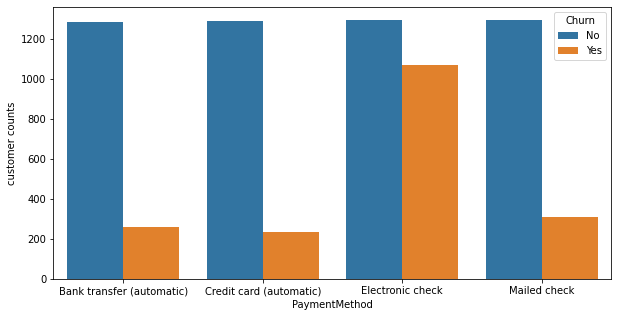

In [70]:
plt.figure(figsize=(10,5))
payment = data.groupby(["PaymentMethod","Churn"]).size().to_frame().reset_index()
payment = payment.rename(columns={0:"customer counts"})
sns.barplot("PaymentMethod","customer counts",hue="Churn",data=payment)

<AxesSubplot:xlabel='PaperlessBilling', ylabel='customer counts'>

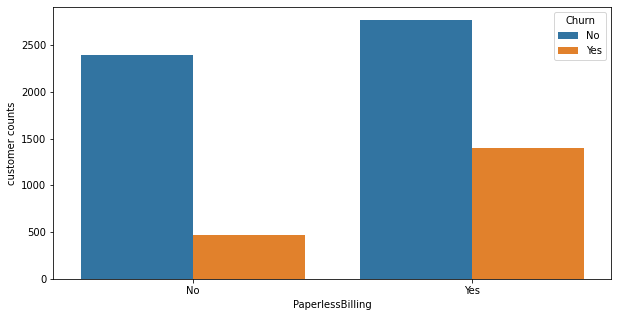

In [71]:
plt.figure(figsize=(10,5))
paperless = data.groupby(["PaperlessBilling","Churn"]).size().to_frame().reset_index()
paperless = paperless.rename(columns={0:"customer counts"})
sns.barplot("PaperlessBilling","customer counts",hue="Churn",data=paperless)

Based on the above bar charts, a large portion of the churned customers have month-to-month contract, which might indicate that they might not stay subscripted for a long term. A large percentage of churned customers pay electronic checks, which might affect their user expereinces, while non-churned customers seem to be evenly distributed across four payment methods. Not much difference for paperless billing among customers, in both churned and non-churned customers, there are more customers with paperless billing.

In [72]:
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [73]:
services = data.loc[:,['PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies']]
services.head()

,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,No,No phone service,DSL,No,Yes,No,No,No,No
1,Yes,No,DSL,Yes,No,Yes,No,No,No
2,Yes,No,DSL,Yes,Yes,No,No,No,No
3,No,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,Yes,No,Fiber optic,No,No,No,No,No,No


<AxesSubplot:xlabel='PaperlessBilling', ylabel='customer counts'>

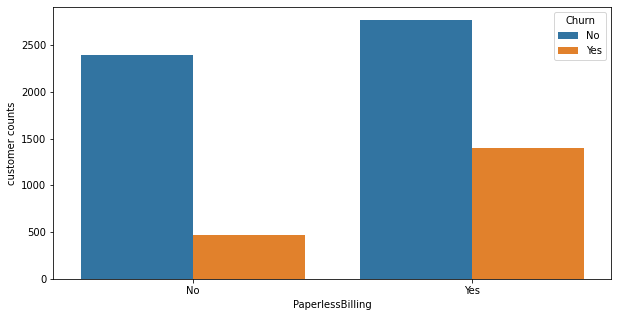

In [74]:
plt.figure(figsize=(10,5))
paperless = data.groupby(["PaperlessBilling","Churn"]).size().to_frame().reset_index()
paperless = paperless.rename(columns={0:"customer counts"})
sns.barplot("PaperlessBilling","customer counts",hue="Churn",data=paperless)

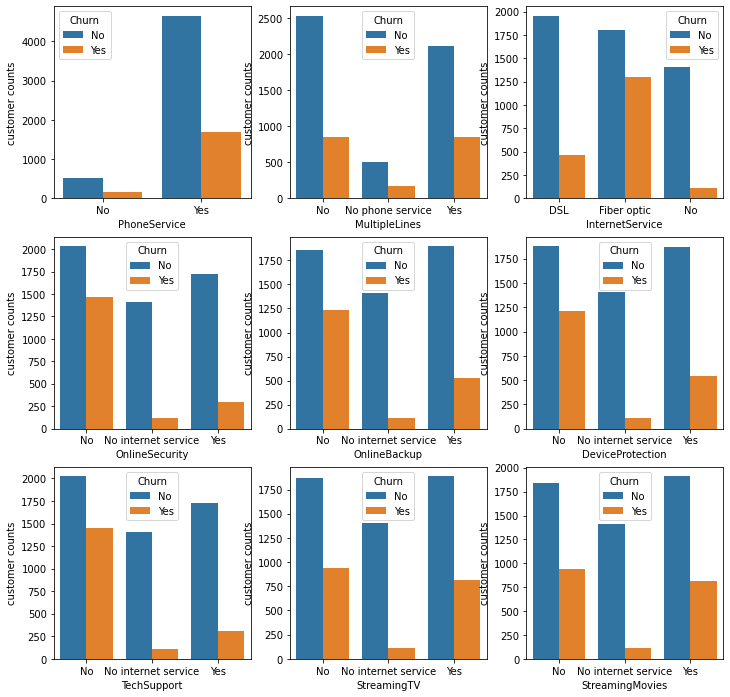

In [75]:
fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(12,12))
j=0
m=0
for i in np.arange(9):
    col = services.columns[i]
    temp = data.groupby([col,"Churn"]).size().to_frame().reset_index()
    temp = temp.rename(columns={0:"customer counts"})

    sns.barplot(col,"customer counts",hue="Churn",data=temp,ax = ax[m][j])
    if j >=2:
        j=0
        m+=1
    elif j<2 :
        j+=1
  

Fiber optic internet service seems to lead many more churns than DSL service. For multiple lines, streaming TV and movie, there are no significant differences among yes or no users, indicating they might not be significant factors compared with other services.

### Example of Chi-Square Test Among Categorical Variables

In [76]:
from scipy.stats import chi2_contingency

In [77]:
#testing relationship between internet service and phone service
contigency= pd.crosstab(data["InternetService"], data['PhoneService'])
contigency

PhoneService,No,Yes
InternetService,,
DSL,680,1736
Fiber optic,0,3096
No,0,1520


In [78]:
c, p, dof, expected = chi2_contingency(contigency)
#p-value
p

0.0

P-value almost zero, indicating strong relationship between having phone services and internet services.
We can use this method to check for relationships of all available categorical variables.

## 3. Modeling
- Logistic Regression
- SVM
- KNN
- Random Forest

In [79]:
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [80]:
data.loc[:,"tenure2"] = data["tenure"]**2
data.loc[:,'MonthlyCharges2'] = data['MonthlyCharges']**2
data.loc[:,'TotalCharges2'] = data['TotalCharges']**2

In [81]:
X = pd.get_dummies(data[['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges']],drop_first=True)
y = data['Churn']

In [82]:
#regular X
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [83]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report

### Logistic Regression

In [84]:
#logistic regression
log_mod = LogisticRegression(max_iter=200)
log_mod.fit(X_train,y_train)

LogisticRegression(max_iter=200)

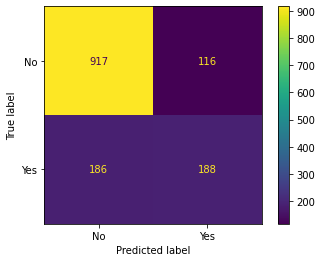

In [85]:
#False as positive label
plot_confusion_matrix(log_mod,X=X_test,y_true=y_test)

In [86]:
#predicted probabilities
log_probs = [x[0] for x in log_mod.predict_proba(X_test)]

In [87]:
#average precision score of the logistic regression model, decent precision
average_precision_score(y_test,log_probs,pos_label="No")

0.9283919936918389

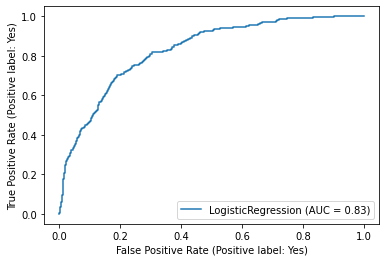

In [88]:
#AUC of the logistic regression model >0.8: decent performance
plot_roc_curve(log_mod,X=X_test,y=y_test)

In [89]:
print(classification_report(y_test, log_mod.predict(X_test)))

              precision    recall  f1-score   support

          No       0.83      0.89      0.86      1033
         Yes       0.62      0.50      0.55       374

    accuracy                           0.79      1407
   macro avg       0.72      0.70      0.71      1407
weighted avg       0.77      0.79      0.78      1407



For churned customer group, the performance is not as good as non-churned customers.

### SVM

In [111]:
svc = SVC(C=10)
svc.fit(X_train,y_train)

SVC(C=10)

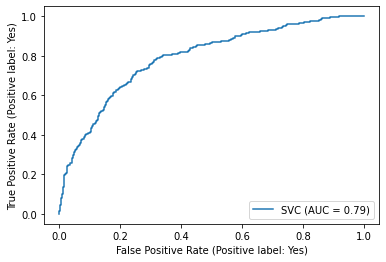

In [112]:
plot_roc_curve(svc,X=X_test,y=y_test)

In [113]:
print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

          No       0.78      0.97      0.86      1033
         Yes       0.74      0.25      0.37       374

    accuracy                           0.78      1407
   macro avg       0.76      0.61      0.62      1407
weighted avg       0.77      0.78      0.73      1407



SVC did a better job in terms of recall for non-churned customers, but worse than losgistic regression for churned customers. AUC is lower.

### Random Forest

In [132]:
forest = RandomForestClassifier(max_depth=20)
forest.fit(X_train,y_train)

RandomForestClassifier(max_depth=20)

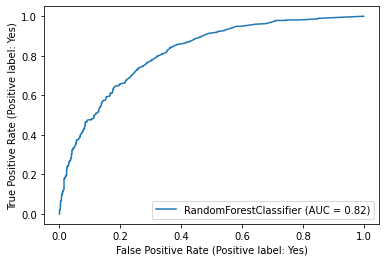

In [133]:
plot_roc_curve(forest,X=X_test,y=y_test)

In [134]:
print(classification_report(y_test, forest.predict(X_test)))

              precision    recall  f1-score   support

          No       0.83      0.91      0.87      1033
         Yes       0.65      0.47      0.55       374

    accuracy                           0.79      1407
   macro avg       0.74      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407



Random Forest performs similarly compared with logistic regression, further hyperparameter tuning can be done with grid search cross validation.

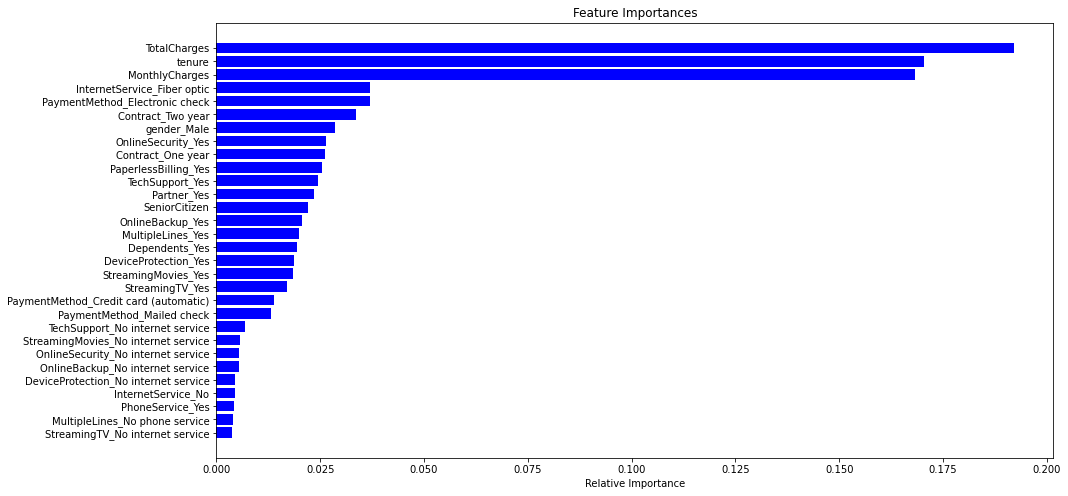

In [142]:
importances = forest.feature_importances_
features = X.columns
indices = np.argsort(importances)
plt.figure(figsize=(15,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Three numerical variables: total charges, tenure and monthly charges are deemed as most important by the random forest, next feature is internet fiber optic, which correponds to the significant difference we see in the internet vs. churn bar chart. As expected, streaming, multilines and other less important services are assigned lower importance values.

### KNN

In [136]:
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)

KNeighborsClassifier()

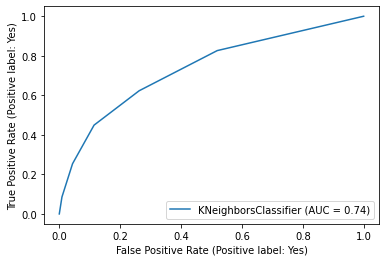

In [137]:
plot_roc_curve(knn,X=X_test,y=y_test)

In [138]:
print(classification_report(y_test, knn.predict(X_test)))

              precision    recall  f1-score   support

          No       0.82      0.89      0.85      1033
         Yes       0.59      0.45      0.51       374

    accuracy                           0.77      1407
   macro avg       0.70      0.67      0.68      1407
weighted avg       0.76      0.77      0.76      1407



Not surprisingly, AUC of KNN is the lowest since KNN suffers high dimensionality, however it does have decent precision and recall for churned class.